In [2]:
!pip install -q flwr[simulation] torch torchvision matplotlib
#This will download and the build the necessary wheels required for the later part of the code to run

     |████████████████████████████████| 121 kB 5.1 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 38.8 MB/s 
     |████████████████████████████████| 4.1 MB 45.3 MB/s 
     |████████████████████████████████| 3.0 MB 45.3 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 201 kB 47.0 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 128 kB 70.4 MB/s 
     |████████████████████████████████| 280 kB 65.2 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 468 kB 54.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.43.0 which is incompatible.
google-cloud-bigquery 3.3.6 requires grp

In [3]:
from collections import OrderedDict
from typing import List, Tuple
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # If you have a CUDA enabled GPU, you can use "cuda" to accelarate your training process

Training on cpu using PyTorch 1.13.0+cu116 and Flower 1.1.0


In [4]:
#lets define some of the classes and hyperparameters 
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [6]:
# we will build a FL service on CIFAR-10 dataset 

def load_datasets():
    #tranformation
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    #split the data into multiple sets based on available clients ( 10 in this code)
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # train test split and data loader to effeciently load data into training
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


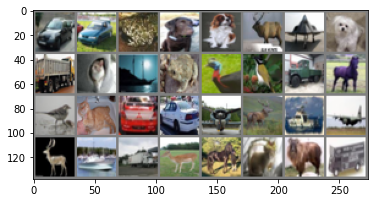

  car   car  frog   dog   dog  deer plane   dog truck   cat  ship  frog  bird  bird truck horse  bird   cat   car   car plane  deer  ship plane  deer  ship truck  deer horse   cat  deer truck


In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize [to display the images]
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = next(iter(trainloaders[0]))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

In [17]:
#Define a simple CNN

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def train(net, trainloader, epochs: int, verbose=False):

    """Training  the network on training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):

    """Evaluate the network on the complete test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy       # return some metrics

In [15]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(50):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06038895583152771, accuracy 0.29
Epoch 2: validation loss 0.056456910610198974, accuracy 0.344
Epoch 3: validation loss 0.05328912734985351, accuracy 0.368
Epoch 4: validation loss 0.05086568069458008, accuracy 0.412
Epoch 5: validation loss 0.05017439770698547, accuracy 0.408
Epoch 6: validation loss 0.04833845138549805, accuracy 0.446
Epoch 7: validation loss 0.04939020299911499, accuracy 0.446
Epoch 8: validation loss 0.04966110587120056, accuracy 0.46
Epoch 9: validation loss 0.04968419671058655, accuracy 0.43
Epoch 10: validation loss 0.047341180086135866, accuracy 0.466
Epoch 11: validation loss 0.04813559651374817, accuracy 0.466
Epoch 12: validation loss 0.050192339658737185, accuracy 0.458
Epoch 13: validation loss 0.05024029588699341, accuracy 0.45
Epoch 14: validation loss 0.05269180846214294, accuracy 0.446
Epoch 15: validation loss 0.05317301404476166, accuracy 0.446
Epoch 16: validation loss 0.050538278579711916, accuracy 0.468
Epoch 17: validat

In [11]:
#Lets do it in the federated way, and customise some configurations
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [13]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [16]:
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
)

INFO flower 2022-12-12 13:02:36,972 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2022-12-12 13:02:40,862	WARNING services.py:1884 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 2429902848 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.09gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-12-12 13:02:42,237	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-12-12 13:02:45,051 | app.py:174 | Flower VCE: Ray initialized with resources: {'memory': 7989163623.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3994581811.0}
INFO:f

History (loss, distributed):
	round 1: 0.0646478847026825
	round 2: 0.05648237748146058
	round 3: 0.05230702133178711
	round 4: 0.05053420038223268
	round 5: 0.04864396543502808
	round 6: 0.046804947328567506
	round 7: 0.04610733077526093
	round 8: 0.045735204935073846
	round 9: 0.04444497442245484
	round 10: 0.04384489455223083
	round 11: 0.04271428253650665
	round 12: 0.042150088858604426
	round 13: 0.04090552613735199
	round 14: 0.04186929016113281
	round 15: 0.040980344271659856
	round 16: 0.04001122899055481
	round 17: 0.03980251207351685
	round 18: 0.03917044105529786
	round 19: 0.038375248670578
	round 20: 0.03836231279373169
	round 21: 0.03764301958084106
	round 22: 0.03813680937290192
	round 23: 0.038411765241622924
	round 24: 0.03641841413974762
	round 25: 0.038038958525657654
	round 26: 0.03773151357173919
	round 27: 0.03636948556900025
	round 28: 0.036757860040664676
	round 29: 0.03637857091426849
	round 30: 0.036326943850517275
	round 31: 0.03534761638641358
	round 32: 0.0